In [1]:
import glob
import os
import json
import pandas as pd
from tqdm.auto import tqdm

import numpy as np
from CotModel import CotModel
from LincModel import LincModel
from NaiveModel import NaiveModel

/root/miniconda3/envs/linc/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
glob.glob(os.path.join("results/folio", '*.json')) + glob.glob(os.path.join("results/proofwriter", '*.json'))

['results/folio/cot - Llama-2-13b-chat-hf (2024-11-29_06-45-56).json',
 'results/folio/cot - Llama-2-7b-chat-hf (2024-11-29_03-23-47).json',
 'results/folio/cot - Llama-3.1-8B-Instruct (2024-11-28_23-55-42).json',
 'results/folio/cot - Llama-3.2-1B-Instruct (2024-11-28_22-34-15).json',
 'results/folio/cot - Llama-3.2-3B-Instruct (2024-11-28_23-11-19).json',
 'results/folio/linc - Llama-2-13b-chat-hf (2024-12-03_03-17-15).json',
 'results/folio/linc - Llama-2-7b-chat-hf (2024-12-02_19-31-08).json',
 'results/folio/linc - Llama-3.1-8B-Instruct (2024-12-02_16-31-56).json',
 'results/folio/linc - Llama-3.2-1B-Instruct (2024-12-02_16-34-24).json',
 'results/folio/linc - Llama-3.2-3B-Instruct (2024-12-02_16-37-29).json',
 'results/folio/naive - Llama-2-13b-chat-hf (2024-11-28_23-06-36).json',
 'results/folio/naive - Llama-2-7b-chat-hf (2024-11-28_22-07-31).json',
 'results/folio/naive - Llama-3.1-8B-Instruct (2024-11-28_21-55-17).json',
 'results/folio/naive - Llama-3.2-1B-Instruct (2024-11-

In [3]:
paths = glob.glob(os.path.join("results/folio", '*.json')) + glob.glob(os.path.join("results/proofwriter", '*.json'))

In [ ]:
def parse_cot(row):
    answers = [CotModel.parse(response) for response in row.responses]
    accuracies = [1 if answer == row["label"] else 0 for answer in answers]
    return answers, accuracies

def parse_linc(row):
    answers = [LincModel.parse(response) for response in row.responses]
    accuracies = [1 if answer == row["label"] else 0 for answer in answers]
    return answers, accuracies

def parse_naive(row):
    answers = [NaiveModel.parse(response) for response in row.responses]
    accuracies = [1 if answer == row["label"] else 0 for answer in answers]
    return answers, accuracies

def get_dataset_path(file_name):
    if "folio" in file_name:
        return "data/folio.csv"
    elif "proofwriter" in file_name:
        return "data/proofwriter.csv"
    else:
        raise Exception()

results_df_dict = {}

for path in tqdm(paths):
    with open(path, "r") as file:
        results = json.load(file)
    data_path = get_dataset_path(path)
    results_df = pd.DataFrame(results)
    results_df["label"] = pd.read_csv(data_path)["label"]

    if "cot" in path:
        results_df[["answers", "accuracies"]] = results_df.apply(lambda row: pd.Series(parse_cot(row)), axis=1)
    elif "linc" in path:
        results_df[["answers", "accuracies"]] = results_df.apply(lambda row: pd.Series(parse_linc(row)), axis=1)
    elif "naive" in path:
        results_df[["answers", "accuracies"]] = results_df.apply(lambda row: pd.Series(parse_naive(row)), axis=1)
    results_df_dict[path] = results_df


100%|██████████| 30/30 [21:35<00:00, 43.20s/it]


In [4]:
import pickle

with open("data/results_df_dict.pkl", "wb") as file:
    pickle.dump(results_df_dict, file)

In [4]:
import pickle

with open("data/results_df_dict.pkl", "rb") as file:
    results_df_dict = pickle.load(file)


In [ ]:
import re

def get_model_choice(file_name):
    if "linc" in file_name:
        return "LINC"
    elif "naive" in file_name:
        return "Naive"
    elif "cot" in file_name:
        return "COT"
    else:
        raise Exception()


def get_model_name(file_name):
    pattern = r"Llama\S*"
    model = re.findall(pattern, file_name)[0]
    conversions = {
        "Llama-2-13b-chat-hf": "Llama 2 13B Chat",
        "Llama-2-7b-chat-hf": "Llama 2 7B Chat",
        "Llama-3.1-8B-Instruct": "Llama 3.1 8B Instruct",
        "Llama-3.2-1B-Instruct": "Llama 3.2 1B Instruct",
        "Llama-3.2-3B-Instruct": "Llama 3.2 3B Instruct",
    }

    for key, value in conversions.items():
        if key in model:
            return model.replace(key, value)
    raise Exception()

def get_dataset_name(file_name):
    if "folio" in file_name:
        return "FOLIO"
    elif "proofwriter" in file_name:
        return "ProofWriter"
    else:
        raise Exception()

all_results = []
for path in tqdm(paths):
    results_df = results_df_dict[path]
    accuracies = np.array(results_df["accuracies"].tolist())
    mean_accuracies = np.round(np.mean(accuracies, axis=0), 4)
    results = {
        "Dataset": get_dataset_name(path),
        "Method": get_model_choice(path),
        "Model": get_model_name(path),
        "Accuracy": np.mean(mean_accuracies),
        "STD": np.std(mean_accuracies, ddof=1) / np.sqrt(np.size(mean_accuracies))
        
    }
    all_results.append(results)

100%|██████████| 30/30 [00:00<00:00, 5788.97it/s]


In [113]:
all_results_df = pd.DataFrame(all_results)
all_results_df

,Dataset,Method,Model,Size,Accuracy,STD
0,FOLIO,COT,Llama 2 13B Chat,13,0.47140,0.005041
1,FOLIO,COT,Llama 2 7B Chat,7,0.10880,0.005872
2,FOLIO,COT,Llama 3.1 8B Instruct,8,0.59780,0.003648
3,FOLIO,COT,Llama 3.2 1B Instruct,1,0.18570,0.007661
4,FOLIO,COT,Llama 3.2 3B Instruct,3,0.47692,0.009252
5,FOLIO,LINC,Llama 2 13B Chat,13,0.30880,0.002694
6,FOLIO,LINC,Llama 2 7B Chat,7,0.21760,0.007501
7,FOLIO,LINC,Llama 3.1 8B Instruct,8,0.61870,0.007894
8,FOLIO,LINC,Llama 3.2 1B Instruct,1,0.17800,0.003300
9,FOLIO,LINC,Llama 3.2 3B Instruct,3,0.33298,0.006627


In [51]:
all_results_df.to_csv("results/results.csv", index=False)

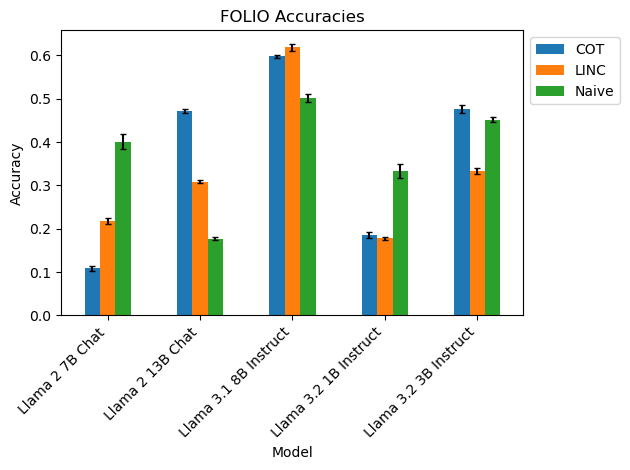

In [130]:
import matplotlib.pyplot as plt

pivot_df = all_results_df[all_results_df["Dataset"] == "FOLIO"].pivot(
    index="Model", columns="Method", values=["Accuracy", "STD"]
)
pivot_df = pivot_df.reindex(
    [
        "Llama 2 7B Chat",
        "Llama 2 13B Chat",
        "Llama 3.1 8B Instruct",
        "Llama 3.2 1B Instruct",
        "Llama 3.2 3B Instruct",
    ]
)
pivot_df

ax = pivot_df.plot(
    kind="bar",
    y="Accuracy",
    yerr="STD",
    linewidth=1,
    capsize=2,
    title="FOLIO Accuracies",
)
ax.set_ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.show()

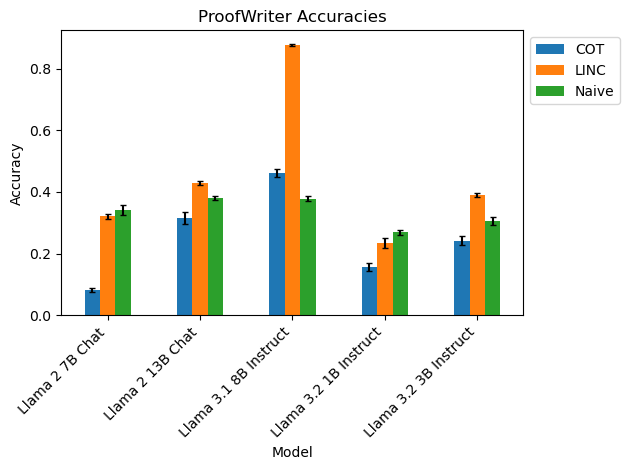

In [131]:
import matplotlib.pyplot as plt

pivot_df = all_results_df[all_results_df["Dataset"] == "ProofWriter"].pivot(
    index="Model", columns="Method", values=["Accuracy", "STD"]
)

pivot_df = pivot_df.reindex(
    [
        "Llama 2 7B Chat",
        "Llama 2 13B Chat",
        "Llama 3.1 8B Instruct",
        "Llama 3.2 1B Instruct",
        "Llama 3.2 3B Instruct",
    ]
)

ax = pivot_df.plot(
    kind="bar",
    y="Accuracy",
    yerr="STD",
    linewidth=1,
    capsize=2,
    title="ProofWriter Accuracies",
)
ax.set_ylabel("Accuracy")
plt.xticks(rotation=45, ha="right")
plt.legend(bbox_to_anchor=(1, 1), loc="upper left")
plt.tight_layout()
plt.show()

In [35]:
all_results_df = pd.read_csv("results/results.csv")

In [ ]:
import matplotlib.pyplot as plt

# Group by model_name and calculate the mean of mean_accuracies
grouped = all_results_df.groupby("model_name")["mean_accuracies"].mean().reset_index()

# Plot the bar chart
plt.figure(figsize=(10, 6))
plt.bar(grouped["model_name"], grouped["mean_accuracies"], color="blue")
plt.xlabel("Model Name")
plt.ylabel("Mean Accuracy")
plt.title("Mean Accuracies by Model Name")
plt.xticks(rotation=45, ha="right")
plt.tight_layout()
plt.show()

In [ ]:
example = results_df_dict["linc - Llama-3.1-8B-Instruct (2024-12-02_18-56-55).json"]
example

,index,responses,label,answers,accuracies,mean
0,0,[[<EVALUATE>\nTEXT: Dave is big.\nFOL: Big(dav...,Uncertain,"[Uncertain, Uncertain, Uncertain, Uncertain, U...","[1, 1, 1, 1, 1]",1.0
1,1,[[<EVALUATE>\nTEXT: The cat is cold.\nFOL: Col...,True,"[Uncertain, Uncertain, Uncertain, Uncertain, U...","[0, 0, 0, 0, 0]",0.0
2,2,[[<EVALUATE>\nTEXT: The cat does not chase the...,Uncertain,"[Uncertain, Uncertain, Uncertain, Uncertain, U...","[1, 1, 1, 1, 1]",1.0
3,3,[[<EVALUATE>\nTEXT: Rough and cold that is wha...,Uncertain,"[Uncertain, Error, Uncertain, Uncertain, Uncer...","[1, 0, 1, 1, 1]",0.8
4,4,[[<EVALUATE>\nTEXT: The cow is big.\nFOL: Big(...,True,"[Uncertain, Uncertain, Uncertain, Uncertain, U...","[0, 0, 0, 0, 0]",0.0
...,...,...,...,...,...,...
177,177,[[<EVALUATE>\nTEXT: The bald eagle eats the sq...,False,"[Uncertain, Uncertain, Uncertain, Uncertain, U...","[0, 0, 0, 0, 0]",0.0
178,178,[[<EVALUATE>\nTEXT: That guy Alan sure is nice...,False,"[Uncertain, Uncertain, Uncertain, Uncertain, U...","[0, 0, 0, 0, 0]",0.0
179,179,"[[<EVALUATE>\nTEXT: Bob may be round, but he i...",False,"[Uncertain, Uncertain, Uncertain, Uncertain, U...","[0, 0, 0, 0, 0]",0.0
180,180,[[<EVALUATE>\nTEXT: The cat eats the rabbit.\n...,Uncertain,"[False, False, False, False, False]","[0, 0, 0, 0, 0]",0.0


In [ ]:
pd.read_csv("data/proofwriter.csv")

,id,premises,question_id,conclusion,label
0,AttNoneg-OWA-D3-953,Dave is big.\r\nDave is green.\r\nDave is red....,Q10,Erin is nice.,Uncertain
1,RelNoneg-OWA-D3-1034,The cat is cold.\r\nThe cat is rough.\r\nThe c...,Q16,The dog needs the rabbit.,Uncertain
2,RelNeg-OWA-D1-829,The cat does not chase the rabbit.\r\nThe cat ...,Q5,The mouse does not visit the cat.,Uncertain
3,AttNonegNatLang-OWA-220,Rough and cold that is what they say about Blu...,Q11,Fred is not nice.,Uncertain
4,RelNoneg-OWA-D1-91,The cow is big.\r\nThe cow is blue.\r\nThe cow...,Q5,The squirrel does not like the squirrel.,Uncertain
...,...,...,...,...,...
177,RelNeg-OWA-D3-1572,The bald eagle eats the squirrel.\r\nThe squir...,Q7,The bald eagle is nice.,True
178,AttNonegNatLang-OWA-44,That guy Alan sure is nice.\r\nThe young perso...,Q16,Gary is green.,Uncertain
179,AttNonegNatLang-OWA-402,"Bob may be round, but he is also kind.\r\nChar...",Q1,Dave is kind.,True
180,RelNeg-OWA-D3-1427,The cat eats the rabbit.\r\nThe rabbit eats th...,Q6,The tiger is not round.,False


In [ ]:
example["responses"]

[["<EVALUATE>\nTEXT: Bob may be round, but he is also kind.\nFOL: (Round(bob) & -Kind(bob)) | Kind(bob)\nTEXT: Charlie may be round, but he is also kind.\nFOL: (Round(charlie) & -Kind(charlie)) | Kind(charlie)\nTEXT: Dave may be round, but he is also kind.\nFOL: (Round(dave) & -Kind(dave)) | Kind(dave)\nTEXT: Eric is green and cold too.\nFOL: Green(eric) & Cold(eric)\nTEXT: Every time you meet someone kind and nice, they'll be green, too.\nFOL: all x. (Kind(x) & Nice(x) -> Green(x))\nTEXT: When green, young and round fits a person, you'll see that rough will also fit.\nFOL: all x. ((Green(x) & Young(x) & Round(x)) -> Rough(x))\nTEXT: Every single big person is a little green in some areas.\nFOL: all x. (Big(x) -> exists y. Green(y) & InSomeAreas(y, x))\nTEXT: When rough and kind can describe a person, then cold will describe them, too.\nFOL: all x. ((Rough(x) & Kind(x)) -> Cold(x))\nTEXT: A kind person will certainly be rough as well.\nFOL: all x. (Kind(x) -> Rough(x))\nTEXT: Nice peop